In [18]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, fcluster, to_tree
from sklearn.cluster import AgglomerativeClustering

In [19]:
DATA_ALL = sio.loadmat("subjects_40_v2.mat")

SIG    = DATA_ALL['DATA']              # raw sEMG signals
FEAT   = DATA_ALL['FEAT']              # Orignally calculated features
FEAT_N = DATA_ALL['FEAT_N']            # Normalized features
LABEL  = DATA_ALL['LABEL']             # Labels
SUBJECT_ID = DATA_ALL['SUBJECT_ID']    # Sujbect ID
LABEL_VOWEL = DATA_ALL['LABEL_VOWEL']
VFI         = DATA_ALL['SUBJECT_VFI']

In [20]:
# Combine all features into one single numpy array
features_all = np.zeros((0,40))
labels_all   = np.zeros((0,1))
subject_id   = np.zeros((0,1))
labels_vowel = np.zeros((0,1))
subject_vfi  = np.zeros((0,1))
for i_sub in range(40):
    features_all = np.append(features_all, FEAT_N[i_sub,0], axis=0)
    labels_all   = np.append(labels_all, LABEL[i_sub,0]   , axis=0)
    subject_id   = np.append(subject_id, SUBJECT_ID[i_sub,0], axis=0)
    labels_vowel = np.append(labels_vowel, LABEL_VOWEL[i_sub,0], axis=0)
    subject_vfi  = np.append(subject_vfi, VFI[i_sub,0], axis=0)
    
num_data = np.size(features_all,0)
labels_indices = np.arange(num_data)

In [21]:
X = features_all

# setting distance_threshold=0 ensures we compute the full tree.
# ward minimizes the variance of the cluster being merged
model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                linkage="ward")
model = model.fit(X)

AgglomerativeClustering Attributes
----------
__n_clusters_ : int__
    The number of clusters found by the algorithm. If
    ``distance_threshold=None``, it will be equal to the given
    ``n_clusters``.
    
__labels_ : ndarray of shape (n_samples)__
    cluster labels for each point
    
__n_leaves_ : int__
    Number of leaves in the hierarchical tree.
    
__n_connected_components_ : int__
    The estimated number of connected components in the graph.
    .. versionadded:: 0.21
        ``n_connected_components_`` was added to replace ``n_components_``.
        
__children_ : array-like of shape (n_samples-1, 2)__
    The children of each non-leaf node. Values less than `n_samples`
    correspond to leaves of the tree which are the original samples.
    A node `i` greater than or equal to `n_samples` is a non-leaf
    node and has children `children_[i - n_samples]`. Alternatively
    at the i-th iteration, children[i][0] and children[i][1]
    are merged to form node `n_samples + i`



In [22]:
# create the counts of samples under each node
counts = np.zeros(model.children_.shape[0])
# print(counts)
n_samples = len(model.labels_)
# print(n_samples)
for i, merge in enumerate(model.children_):
    current_count = 0

    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, 
                                  model.distances_,
                                  counts]).astype(float)


Ploting Parameters
----------
Z : ndarray
    The linkage matrix encoding the hierarchical clustering to
    render as a dendrogram. See the ``linkage`` function for more
    information on the format of ``Z``.
    
p : int, optional
    The ``p`` parameter for ``truncate_mode``.
    
truncate_mode : str, optional
    ``'level'``
    No more than ``p`` levels of the dendrogram tree are displayed.
    A "level" includes all nodes with ``p`` merges from the last merge.
    Note: ``'mtica'`` is an alias for ``'level'`` that's kept for
    backward compatibility.


In [23]:
print("Children")
print(model.children_.shape)
print(model.children_)

print("# of leaves")
print(model.n_leaves_)

print("Distances")
print(model.distances_.shape)
print(model.distances_)

Children
(6471, 2)
[[ 1534  1535]
 [ 2933  2935]
 [ 1975  1977]
 ...
 [12933 12937]
 [12938 12940]
 [12939 12941]]
# of leaves
6472
Distances
(6471,)
[  0.           0.           0.         ... 246.96358916 259.98833902
 353.98265431]


## Initial Plot
All settings were in default

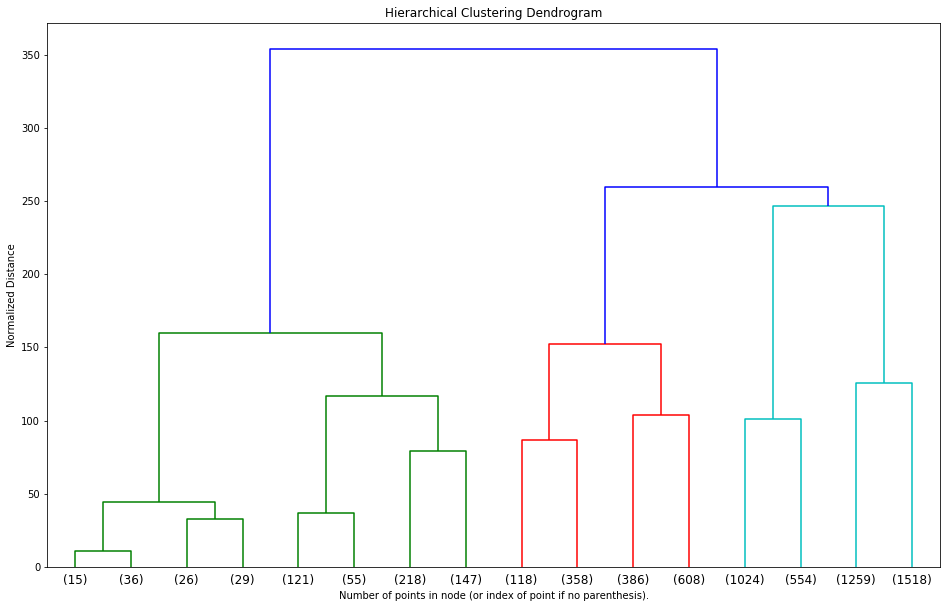

In [24]:
%matplotlib inline

plt.figure(figsize=(16,10))
plt.title('Hierarchical Clustering Dendrogram')
# Plot the corresponding dendrogram
Y = dendrogram(linkage_matrix, 
               truncate_mode='level', 
               p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Normalized Distance")
plt.show()

Showing the Distance on top of each cluster node where each cluster merges to the next level

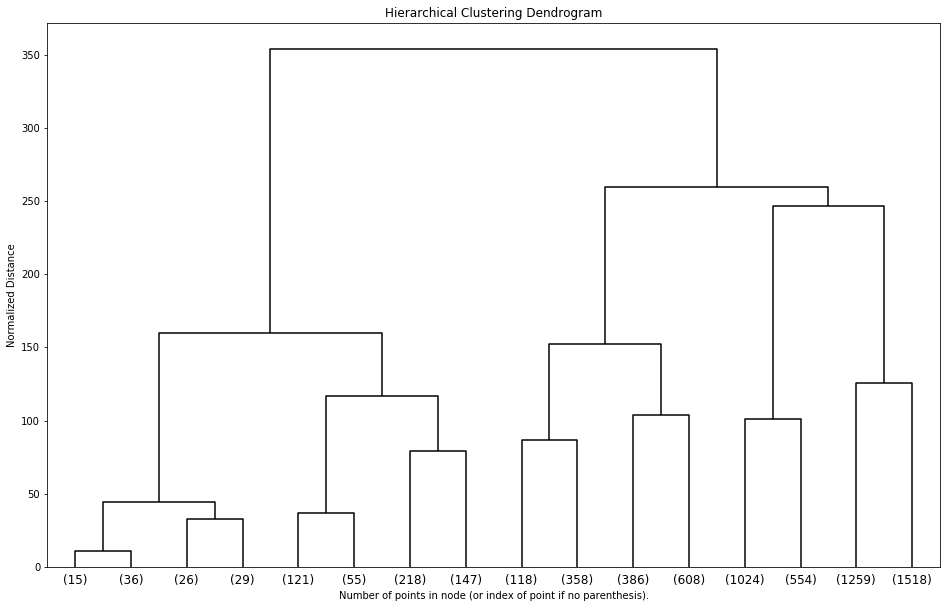

In [25]:
plt.figure(figsize=(16,10))
plt.title('Hierarchical Clustering Dendrogram')
# Plot the corresponding dendrogram
ddata = dendrogram(linkage_matrix, 
                   truncate_mode='level', 
                   p=3,
                   color_threshold=0,
                   above_threshold_color='k')

# for i, d in zip(ddata['icoord'], ddata['dcoord']):
#     x = 0.5 * sum(i[1:3])
#     y = d[1]
#     plt.plot(x, y, 'ro')
#     plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
#                  textcoords='offset points',
#                  va='top', ha='center')

plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Normalized Distance")
plt.show()

## Plot the corresponding % of healthy and fatigued samples 

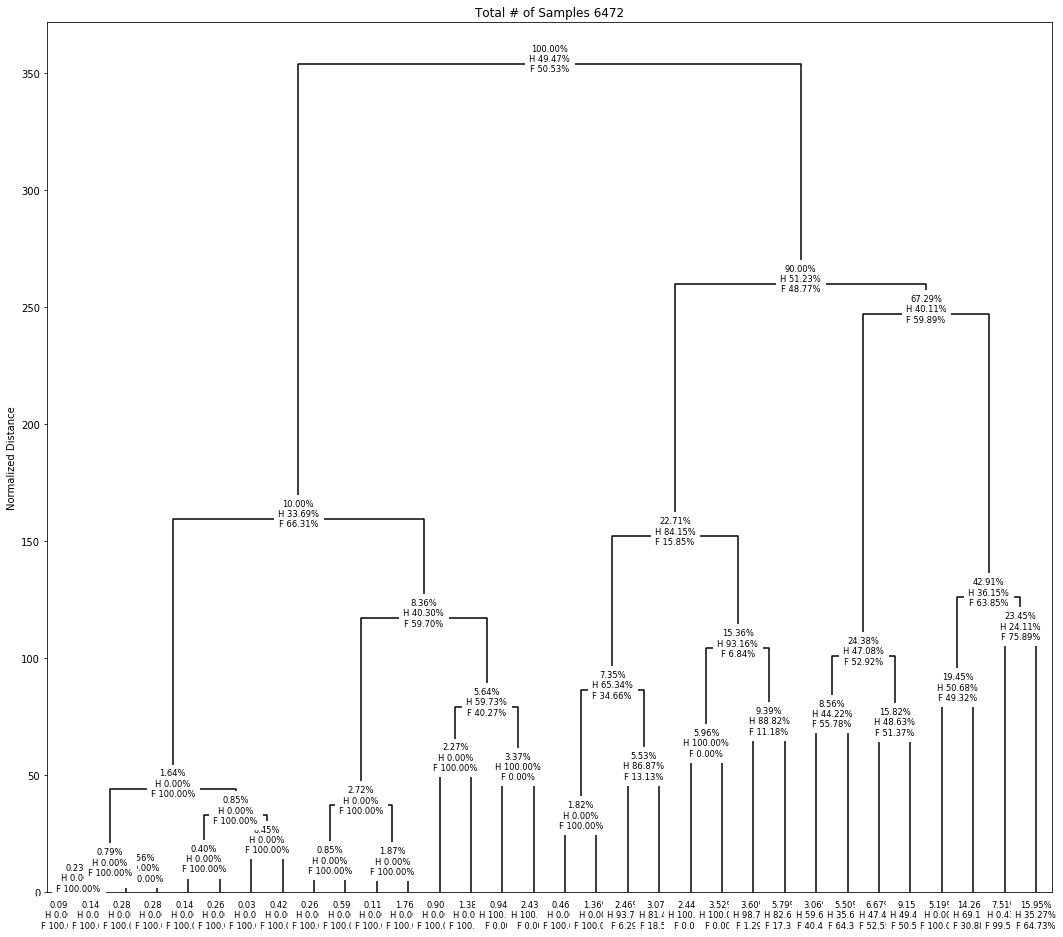

In [26]:
t_level = 4
N = np.size(linkage_matrix,0)+1

plt.figure(figsize=(18,16))
plt.title('Total # of Samples %d' % N)
# Plot the corresponding dendrogram
# The option for truncation is to limit the maximum amount of cluster merge
ddata = dendrogram(linkage_matrix, 
                   truncate_mode='level', 
                   p=t_level,
                   color_threshold=0,
                   above_threshold_color='k',
                   get_leaves=True,
                   labels=None,
                   show_leaf_counts=False,
                   no_labels=False,
                   count_sort='ascending',
                   show_contracted=False)

# Retrieve all sample indices from the plotted cluster nodes by travelsing 
cluster_node = []
cluster_node.append(to_tree(linkage_matrix))

cluster_dist = []
cluster_sampleIdx = []
for i in range(t_level+1):
    cluster_node_next = []
    for node in cluster_node:
        cluster_dist.append(node.dist)
        cluster_sampleIdx.append(node.pre_order())
        cluster_node_next.append(node.get_left())
        cluster_node_next.append(node.get_right())
        
    cluster_node = cluster_node_next

leaf_id = []
leaf_sampleIdx = []
for node in cluster_node:
    leaf_id.append(node.id)
    leaf_sampleIdx.append(node.pre_order())

leaf_i = []
for i, d in zip(ddata['icoord'], ddata['dcoord']):
    x = 0.5 * sum(i[1:3])
    y = d[1]
    
    if d[0] == 0:
        leaf_i.append(i[0])
        leaf_i.append(i[3])
    
    # find the corresponding list of indices from the cluster node
    idx = cluster_dist.index(y)
    pos = sum(np.ravel(labels_all[cluster_sampleIdx[idx]]==1))/len(cluster_sampleIdx[idx])
    neg = sum(np.ravel(labels_all[cluster_sampleIdx[idx]]==-1))/len(cluster_sampleIdx[idx])
      
    plt.annotate("%.2f%%\nH %.2f%%\nF %.2f%%" %(100*len(cluster_sampleIdx[idx])/N, 100*neg, 100*pos), 
                 (x, y), 
                 xytext=(+0, +20),
                 textcoords='offset points',
                 fontsize='small',
                 backgroundcolor="w",
                 va='top', 
                 ha='center')

for i, c_id in zip(leaf_i, ddata['leaves']):
    x = i
    idx = leaf_id.index(c_id)
    tot = len(leaf_sampleIdx[idx])/N
    pos = sum(np.ravel(labels_all[leaf_sampleIdx[idx]]==1))/len(leaf_sampleIdx[idx])
    neg = sum(np.ravel(labels_all[leaf_sampleIdx[idx]]==-1))/len(leaf_sampleIdx[idx])    

    plt.annotate("%.2f%%\nH %.2f%%\nF %.2f%%" %(100*tot, 100*neg, 100*pos), 
                 (x, 0), 
                 xytext=(+0, -8),
                 textcoords='offset points',
                 fontsize='small',
                 backgroundcolor="w",
                 va='top', 
                 ha='center')    
        
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Normalized Distance")
plt.show()

In [10]:
VFI_LIST = sio.loadmat("Notes/VFI_new_matched.mat")
VFI_1 = np.ravel(VFI_LIST['VFI1'])
VFI_2 = np.ravel(VFI_LIST['VFI2'])

## Cluster at a fixed threshold and then classify based on label assignment

In [15]:
cluster_label = fcluster(linkage_matrix, t=50, criterion='distance')
print(sum(cluster_label==1))


NameError: name 'ddata_full' is not defined

In [11]:
cluster_id = ddata['leaves'][-4:]
for c_id in cluster_id:
    idx = leaf_id.index(c_id)
    sample_ids = leaf_sampleIdx[idx]
    
    # General information of the cluster
    tot = len(sample_ids)/N
    pos = sum(np.ravel(labels_all[sample_ids]==1))/len(sample_ids)
    neg = sum(np.ravel(labels_all[sample_ids]==-1))/len(sample_ids)   
    
    # Information of subject ID, VFI-1, and vowels
    subject_list = []
    for sub in np.ravel(subject_id[sample_ids]):
        if sub not in subject_list:
            subject_list.append(sub)
    print('====================================')
    print('Total:    %.2f%% (%3d)'%(100*tot, len(sample_ids)))
    print('====================================')    
    print('Healthy:  %.2f%%'%(100*neg))
    print('Fatigued: %.2f%%'%(100*pos))
    
    for s_id in subject_list:
        size = sum(subject_id[sample_ids]==s_id)
        print('R%02d, %5.2f%%(%3d), VFI-1=%2d, VFI-2=%2d'%(s_id, 
                                                           100*size/len(sample_ids), 
                                                           size, 
                                                           VFI_1[s_id.astype(int)-1],
                                                           VFI_2[s_id.astype(int)-1]))

    print()
#     print(subject_list)
    

Total:    8.56% (554)
Healthy:  44.22%
Fatigued: 55.78%
R34,  9.93%( 55), VFI-1= 0, VFI-2= 0
R46,  2.71%( 15), VFI-1=18, VFI-2= 8
R50, 19.68%(109), VFI-1=17, VFI-2= 3
R32, 13.36%( 74), VFI-1=11, VFI-2= 0
R39,  0.36%(  2), VFI-1= 4, VFI-2= 0
R90,  2.35%( 13), VFI-1= 3, VFI-2= 0
R85, 10.11%( 56), VFI-1= 1, VFI-2= 0
R47,  5.23%( 29), VFI-1=24, VFI-2=10
R49,  0.36%(  2), VFI-1=28, VFI-2=12
R41,  0.18%(  1), VFI-1= 2, VFI-2= 0
R19,  6.86%( 38), VFI-1=22, VFI-2= 3
R88, 20.94%(116), VFI-1= 4, VFI-2= 2
R11,  7.58%( 42), VFI-1=23, VFI-2= 7
R16,  0.36%(  2), VFI-1= 4, VFI-2= 0

Total:    15.82% (1024)
Healthy:  48.63%
Fatigued: 51.37%
R85, 10.35%(106), VFI-1= 1, VFI-2= 0
R84,  0.20%(  2), VFI-1= 1, VFI-2= 0
R90,  4.20%( 43), VFI-1= 3, VFI-2= 0
R30,  4.88%( 50), VFI-1=11, VFI-2= 8
R50,  5.37%( 55), VFI-1=17, VFI-2= 3
R29,  2.44%( 25), VFI-1= 1, VFI-2= 0
R34,  5.76%( 59), VFI-1= 0, VFI-2= 0
R52,  0.59%(  6), VFI-1= 1, VFI-2= 0
R41,  0.59%(  6), VFI-1= 2, VFI-2= 0
R37,  0.20%(  2), VFI-1= 0, VFI-2=

## Clustering only through individual vowels

In [12]:
# 1. Get the samples that are the same vowel
vowel = 3

label_text=['/a/', '/u/', '/i/']

X = features_all[np.ravel(labels_vowel == vowel)]
label_vowel = labels_all[np.ravel(labels_vowel == vowel)]

model = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None,
                                linkage="ward")
model = model.fit(X)

# 2. Build the linkage matrix
# create the counts of samples under each node
counts = np.zeros(model.children_.shape[0])
# print(counts)
n_samples = len(model.labels_)
# print(n_samples)
for i, merge in enumerate(model.children_):
    current_count = 0

    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, 
                                  model.distances_,
                                  counts]).astype(float)

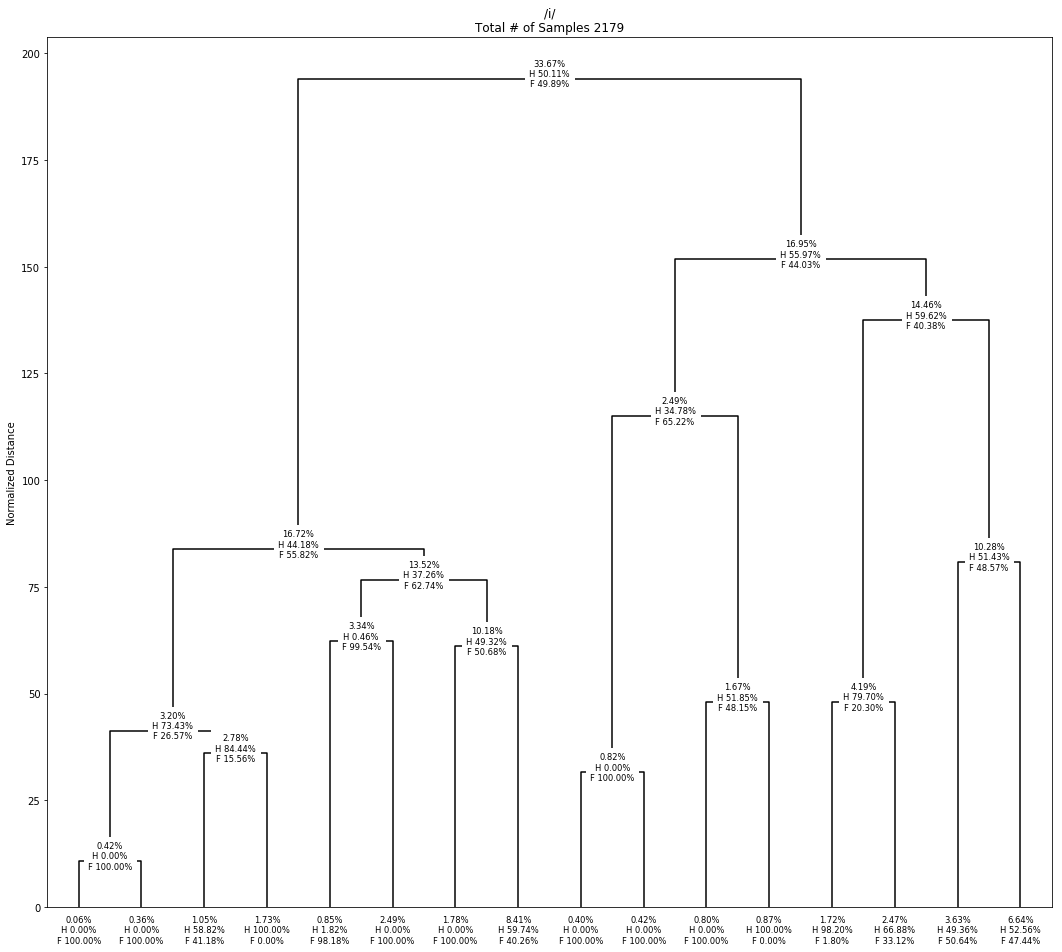

In [13]:
%matplotlib inline

t_level = 3
N = np.size(linkage_matrix,0)+1

plt.figure(figsize=(18,16))
plt.title('%s\nTotal # of Samples %d' % (label_text[vowel-1], N))
# Plot the corresponding dendrogram
# The option for truncation is to limit the maximum amount of cluster merge
ddata = dendrogram(linkage_matrix, 
                   truncate_mode='level', 
                   p=t_level,
                   color_threshold=0,
                   above_threshold_color='k',
                   get_leaves=True,
                   labels=None,
                   show_leaf_counts=False,
                   no_labels=False,
                   count_sort='ascending',
                   show_contracted=False)

# Retrieve all sample indices from the plotted cluster nodes by travelsing 
cluster_node = []
cluster_node.append(to_tree(linkage_matrix))

cluster_dist = []
cluster_sampleIdx = []
for i in range(t_level+1):
    cluster_node_next = []
    for node in cluster_node:
        cluster_dist.append(node.dist)
        cluster_sampleIdx.append(node.pre_order())
        cluster_node_next.append(node.get_left())
        cluster_node_next.append(node.get_right())
        
    cluster_node = cluster_node_next

leaf_id = []
leaf_sampleIdx = []
for node in cluster_node:
    leaf_id.append(node.id)
    leaf_sampleIdx.append(node.pre_order())

leaf_i = []
for i, d in zip(ddata['icoord'], ddata['dcoord']):
    x = 0.5 * sum(i[1:3])
    y = d[1]
    
    if d[0] == 0:
        leaf_i.append(i[0])
        leaf_i.append(i[3])
    
    # find the corresponding list of indices from the cluster node
    idx = cluster_dist.index(y)
    pos = sum(np.ravel(label_vowel[cluster_sampleIdx[idx]]==1))/len(cluster_sampleIdx[idx])
    neg = sum(np.ravel(label_vowel[cluster_sampleIdx[idx]]==-1))/len(cluster_sampleIdx[idx])
      
    plt.annotate("%.2f%%\nH %.2f%%\nF %.2f%%" %(100*len(cluster_sampleIdx[idx])/num_data, 100*neg, 100*pos), 
                 (x, y), 
                 xytext=(+0, +20),
                 textcoords='offset points',
                 fontsize='small',
                 backgroundcolor="w",
                 va='top', 
                 ha='center')

for i, c_id in zip(leaf_i, ddata['leaves']):
    x = i
    idx = leaf_id.index(c_id)
    tot = len(leaf_sampleIdx[idx])/num_data
    pos = sum(np.ravel(label_vowel[leaf_sampleIdx[idx]]==1))/len(leaf_sampleIdx[idx])
    neg = sum(np.ravel(label_vowel[leaf_sampleIdx[idx]]==-1))/len(leaf_sampleIdx[idx])
    
    plt.annotate("%.2f%%\nH %.2f%%\nF %.2f%%" %(100*tot, 100*neg, 100*pos), 
                 (x, 0), 
                 xytext=(+0, -8),
                 textcoords='offset points',
                 fontsize='small',
                 backgroundcolor="w",
                 va='top', 
                 ha='center')    
        
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Normalized Distance")
plt.show()

In [16]:
Y = fcluster(linkage_matrix, t=10.5, criterion='distance')
print(max(Y))

59


## Represent the Clusters based on Labels (Healthy or Fatigued)

In [ ]:
Y = fcluster(linkage_matrix, t=275, criterion='distance')

print('Total Samples: %d'%sum(Y==1))
print('Negative Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y == 1] == -1))/sum(Y==1)))
print('Positive Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y == 1] == 1))/sum(Y==1)))

print('Total Samples: %d'%sum(Y==2))
print('Negative Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y == 2] == -1))/sum(Y==2)))
print('Positive Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y == 2] ==  1))/sum(Y==2)))

In [ ]:
Y = fcluster(linkage_matrix, t=250, criterion='distance')

for l in range(max(Y)):
    print('Total Samples: %d'%sum(Y==l+1))
    print('Negative Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y==l+1] == -1))/sum(Y==l+1)))
    print('Positive Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y==l+1] == 1))/sum(Y==l+1)))    

In [ ]:
Y = fcluster(linkage_matrix, t=175, criterion='distance')

for l in range(max(Y)):
    print('Total Samples: %d'%sum(Y==l+1))
    print('Negative Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y==l+1] == -1))/sum(Y==l+1)))
    print('Positive Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y==l+1] == 1))/sum(Y==l+1)))  

In [ ]:
Y = fcluster(linkage_matrix, t=140, criterion='distance')

for l in range(max(Y)):
    print('Total Samples: %d'%sum(Y==l+1))
    print('Negative Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y==l+1] == -1))/sum(Y==l+1)))
    print('Positive Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y==l+1] == 1))/sum(Y==l+1)))  

## Represent the Clusters based on Subjects

In [ ]:
Y = fcluster(linkage_matrix, t=100, criterion='distance')
print(max(Y))
for l in range(max(Y)):
    print('Total Samples: %d'%sum(Y==l+1))
    print('Negative Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y==l+1] == -1))/sum(Y==l+1)))
    print('Positive Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y==l+1] == 1))/sum(Y==l+1)))  

In [ ]:
print('Total Samples: %d'%sum(Y==1))
print(np.ravel(subject_id[Y==1]))

In [ ]:
print('Total Samples: %d'%sum(Y==2))
print(np.ravel(subject_id[Y==2]))

In [ ]:
print('Total Samples: %d'%sum(Y==3))
print(np.ravel(subject_id[Y==3]))

In [ ]:
print('Total Samples: %d'%sum(Y==4))
print(np.ravel(subject_id[Y==4]))

## Represent the Clusters based on Vowels (Healthy or Fatigued)

In [ ]:
print('Total Samples: %d'%sum(Y==1))
print(np.ravel(labels_vowel[Y==1]))

In [ ]:
print('Total Samples: %d'%sum(Y==2))
print(np.ravel(labels_vowel[Y==2]))

## Represent the clusters based on VFI

In [ ]:
cluster_id = 1

print('Subject VFI from Samples in the cluster')
print(np.ravel(subject_id[Y==cluster_id]))
print(np.ravel(subject_vfi[Y==cluster_id]))

In [ ]:
cluster_id = 2

print('Subject VFI from Samples in the cluster')
print(np.ravel(subject_vfi[Y==cluster_id]))

In [ ]:
cluster_id = 3

print('Subject VFI from Samples in the cluster')
print(np.ravel(subject_vfi[Y==cluster_id]))

In [ ]:
cluster_id = 4

print('Subject VFI from Samples in the cluster')
print(np.ravel(subject_vfi[Y==cluster_id]))

In [ ]:
cluster_id = 5

print('Subject VFI from Samples in the cluster')
print(np.ravel(subject_vfi[Y==cluster_id]))

In [ ]:
cluster_id = 6

print('Subject VFI from Samples in the cluster')
print(np.ravel(subject_vfi[Y==cluster_id]))

In [ ]:
cluster_id = 10

print('Subject VFI from Samples in the cluster')
print(np.ravel(subject_vfi[Y==cluster_id]))

## Represent the clusters based on all info

In [ ]:
cluster_id = 2

print('Total Samples: %d'%sum(Y==cluster_id))
print('Negative Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y==cluster_id] == -1))/sum(Y==cluster_id)))
print('Positive Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y==cluster_id] ==  1))/sum(Y==cluster_id)))  
print(np.ravel(subject_id[Y==cluster_id]))
print(np.ravel(labels_vowel[Y==cluster_id]))

In [ ]:
cluster_id = 3

print('Total Samples: %d'%sum(Y==cluster_id))
print('Negative Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y==cluster_id] == -1))/sum(Y==cluster_id)))
print('Positive Samples: %.2f%%'%(100*sum(np.ravel(labels_all[Y==cluster_id] ==  1))/sum(Y==cluster_id)))  
print(np.ravel(subject_id[Y==cluster_id]))
print(np.ravel(labels_vowel[Y==cluster_id]))
print(np.ravel(subject_vfi[Y==cluster_id]))